In [1]:
import pandas as pd

In [2]:
import xml.etree.ElementTree as ET
from xml.etree.ElementTree import Element
# from lxml import etree
from copy import copy
import os
import inspect
from xml.dom import minidom

In [3]:
import math

In [4]:
import networkx as nx

In [5]:
from networkx import DiGraph

In [6]:
from vrpy import VehicleRoutingProblem

In [7]:
import matplotlib.pyplot as plt 

In [8]:
# We need to know the depot using the carrier file
c_df = pd.read_csv('input_file/carrier_mock_up.csv')

In [9]:
c_df.head()

,carrier_id,firm_id,depotLoc_x,depotLoc_y,contract_firms,num_veh_type_1,num_veh_type_2,num_veh_type_3,num_veh_type_4,num_veh_type_5,num_veh_type_6,num_veh_type_7,num_veh_type_8,num_veh_type_9,note
0,1,1,50,50,(1),NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,beverage
1,2,1,0,0,(1),NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,beverage
2,3,2,25,25,"(20, 25)",NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,3pl
3,4,3,10,10,"(30,31,32)",NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,3pl
4,5,4,90,90,(4),NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,construction


In [10]:
c_df = c_df.fillna(0); # Fill all nan with zeros

### Focus on solving a small problem for carrier 2

In [11]:
# Create an empty Directed graph and add the depot as source and sink to the digraph
g = DiGraph()

pos = dict()

#### Now adding all the delivery locations and demand

In [12]:
# reading payload definition
p_df = pd.read_csv('input_file/payload_mock_up.csv')

In [13]:
# problem carrier id
carrier_id = 2;

In [14]:
p_df.head()

,payload_id,carrier_id,sequence_id,tour_id,commodity,weight,job,pu_loc_x,pu_loc_y,del_loc_x,del_loc_y,pu_stop_duration,del_stop_duration,pu_tw_lower,pu_tw_upper,del_tw_lower,del_tw_upper,pu_arrival_time,del_arrival_time
0,1,2,NaN,NaN,4,"10,000",delivery,NaN,NaN,97.0,49.0,NaN,60.0,NaN,NaN,480.0,960.0,NaN,NaN
1,2,2,NaN,NaN,4,"5,000",delivery,NaN,NaN,80.0,92.0,NaN,20.0,NaN,NaN,660.0,780.0,NaN,NaN
2,3,2,NaN,NaN,4,"18,000",delivery,NaN,NaN,18.0,88.0,NaN,80.0,NaN,NaN,480.0,960.0,NaN,NaN
3,4,2,NaN,NaN,4,"3,000",delivery,NaN,NaN,87.0,58.0,NaN,20.0,NaN,NaN,660.0,960.0,NaN,NaN
4,5,2,NaN,NaN,4,"2,000",delivery,NaN,NaN,34.0,4.0,NaN,20.0,NaN,NaN,480.0,960.0,NaN,NaN


In [15]:
# To simplify the problem, look at a small proble with same carrier and same commodity id
df_prob = p_df[(p_df['carrier_id'] == 2)]

In [16]:
df_prob.head()

,payload_id,carrier_id,sequence_id,tour_id,commodity,weight,job,pu_loc_x,pu_loc_y,del_loc_x,del_loc_y,pu_stop_duration,del_stop_duration,pu_tw_lower,pu_tw_upper,del_tw_lower,del_tw_upper,pu_arrival_time,del_arrival_time
0,1,2,NaN,NaN,4,"10,000",delivery,NaN,NaN,97.0,49.0,NaN,60.0,NaN,NaN,480.0,960.0,NaN,NaN
1,2,2,NaN,NaN,4,"5,000",delivery,NaN,NaN,80.0,92.0,NaN,20.0,NaN,NaN,660.0,780.0,NaN,NaN
2,3,2,NaN,NaN,4,"18,000",delivery,NaN,NaN,18.0,88.0,NaN,80.0,NaN,NaN,480.0,960.0,NaN,NaN
3,4,2,NaN,NaN,4,"3,000",delivery,NaN,NaN,87.0,58.0,NaN,20.0,NaN,NaN,660.0,960.0,NaN,NaN
4,5,2,NaN,NaN,4,"2,000",delivery,NaN,NaN,34.0,4.0,NaN,20.0,NaN,NaN,480.0,960.0,NaN,NaN


In [17]:
# Drop nan's columns
df_prob = df_prob.dropna(axis=1, how='all')

In [18]:
df_prob.head()

,payload_id,carrier_id,commodity,weight,job,del_loc_x,del_loc_y,del_stop_duration,del_tw_lower,del_tw_upper
0,1,2,4,"10,000",delivery,97.0,49.0,60.0,480.0,960.0
1,2,2,4,"5,000",delivery,80.0,92.0,20.0,660.0,780.0
2,3,2,4,"18,000",delivery,18.0,88.0,80.0,480.0,960.0
3,4,2,4,"3,000",delivery,87.0,58.0,20.0,660.0,960.0
4,5,2,4,"2,000",delivery,34.0,4.0,20.0,480.0,960.0


In [19]:
### TO DO: ask Kyungsoo to remove the extra space in 'payload_id '
# What is the time units used?

In [20]:
for i in df_prob['payload_id '].unique():  # Can we assume that payload id's are unique?
    g.add_node(i, pos=(float(df_prob.loc[df_prob['payload_id '] == i]['del_loc_x'].values[0]),
          float(df_prob.loc[df_prob['payload_id '] == i]['del_loc_y'].values[0])))
    pos[i] = (float(df_prob.loc[df_prob['payload_id '] == i]['del_loc_x'].values[0]),
          float(df_prob.loc[df_prob['payload_id '] == i]['del_loc_y'].values[0]))

In [21]:
g = nx.complete_graph(df_prob['payload_id '].unique(), create_using=None)
g = g.to_directed()

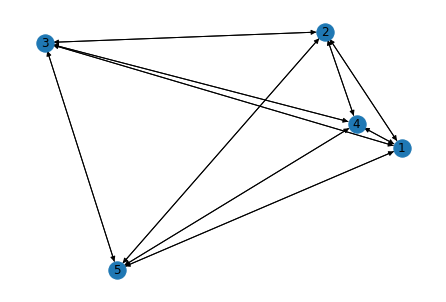

In [22]:
nx.draw(g, pos, with_labels = True)

### Adding demand, time-window and service time

In [23]:
for i in df_prob['payload_id '].unique():    
    # Add demand for this payload
    g.nodes[i]["demand"] = float(df_prob.loc[df_prob['payload_id '] == i]['weight'].values[0].strip().replace(',',''))
    g.nodes[i]["lower"] = float(df_prob.loc[df_prob['payload_id '] == i]['del_tw_lower'].values[0])
    g.nodes[i]["upper"] = float(df_prob.loc[df_prob['payload_id '] == i]['del_tw_upper'].values[0])
    g.nodes[i]["service_time"] = float(df_prob.loc[df_prob['payload_id '] == i]['del_stop_duration'].values[0])

### Add edges between nodes

In [24]:
for edge in g.edges():
    startnode=edge[0] 
    endnode=edge[1]
    g[startnode][endnode]['cost']=round(math.sqrt(((pos[endnode][1]-pos[startnode][1])**2)+
                                      ((pos[endnode][0]-pos[startnode][0])**2)),2)

#### Adding source and sink, and edges going to them

In [25]:
depot_loc = (float(c_df.loc[c_df['carrier_id'] == 2]['depotLoc_x'].values[0]),
          float(c_df.loc[c_df['carrier_id'] == 2]['depotLoc_y'].values[0]))

g.add_node("Source", pos=depot_loc)
pos["Source"] = depot_loc
# Sink location is same as depo 
g.add_node("Sink", pos=(depot_loc[0],depot_loc[0] + 0))
pos["Sink"] = (depot_loc[0],depot_loc[0] + 0)

for i in df_prob['payload_id '].unique():  # Can we assume that payload id's are unique?
    # Add edge to source and sink
    dist = round(math.sqrt(((pos["Source"][1]-pos[i][1])**2)+
                                      ((pos["Source"][0]-pos[i][0])**2)),2)
    print("distance is ", dist)
    g.add_edge(i, "Sink", cost=round(math.sqrt(((pos["Source"][1]-pos[i][1])**2)+
                                      ((pos["Source"][0]-pos[i][0])**2)),2))
    g.add_edge("Source", i, cost=round(math.sqrt(((pos["Source"][1]-pos[i][1])**2)+
                                      ((pos["Source"][0]-pos[i][0])**2)),2))

distance is  108.67
distance is  121.92
distance is  89.82
distance is  104.56
distance is  34.23


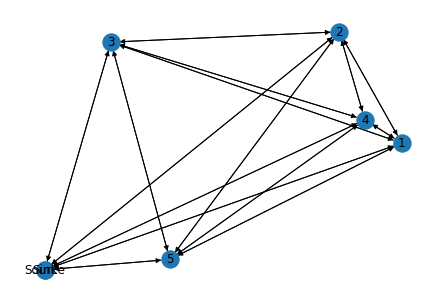

In [26]:
nx.draw(g, pos, with_labels = True)

### Solve Vehicle Routing Problem

In [27]:
# TODO
# Add vehicle composition from data frame
# Add time window constraints

In [36]:
prob = VehicleRoutingProblem(g, load_capacity=20000)
prob.num_vehicles = 4
prob.time_windows = True

In [37]:
prob.solve()

INFO:vrpy.vrp:new upper bound : max num stops = 6
INFO:vrpy.vrp:iteration 0, 100000
INFO:vrpy.vrp:iteration 1, 879.85
INFO:vrpy.master_solve_pulp:total cost = 879.8599999999999


In [38]:
prob.best_value

879.8599999999999

In [39]:
prob.best_routes

{1: ['Source', 1, 'Sink'],
 2: ['Source', 2, 'Sink'],
 3: ['Source', 4, 'Sink'],
 4: ['Source', 5, 3, 'Sink']}

### We also need to know what type of vehicles can take the commodity of interest

In [ ]:
v_df = pd.read_csv('input_file/vehicle_types_mock_up.csv')

In [32]:
v_df.head()

,veh_type_id,veh_category,veh_class,body_type,commodities,weight,length,payload_capacity_weight,payload_capacity_cbf,max_speed,primary_fuel_type,secondary_fuel_type,primary_fuel_rate,secondary_fuel_rate,Automation level,monetary cost
0,1,MD,3,van,(1),12000,6,10000,NaN,80,diesel,NaN,10,NaN,0,NaN
1,2,MD,5,van,(1),17000,8,12000,NaN,80,diesel,NaN,9,NaN,0,NaN
2,3,MD,6,box_van,"(1,2)",22000,8,15000,NaN,65,diesel,NaN,8,NaN,0,NaN
3,4,HD,7,construction,(3),33000,10,30000,NaN,60,diesel,NaN,7,NaN,0,NaN
4,5,HD,7,beverage,(4),30000,10,20000,NaN,60,diesel,NaN,7,NaN,0,NaN


In [33]:
v_df = v_df.dropna(axis=1, how='all')

In [34]:
v_df.head()

,veh_type_id,veh_category,veh_class,body_type,commodities,weight,length,payload_capacity_weight,max_speed,primary_fuel_type,primary_fuel_rate,Automation level
0,1,MD,3,van,(1),12000,6,10000,80,diesel,10,0
1,2,MD,5,van,(1),17000,8,12000,80,diesel,9,0
2,3,MD,6,box_van,"(1,2)",22000,8,15000,65,diesel,8,0
3,4,HD,7,construction,(3),33000,10,30000,60,diesel,7,0
4,5,HD,7,beverage,(4),30000,10,20000,60,diesel,7,0


In [35]:
f_df = pd.read_csv('input_file/freight_vehicles_mock_up.csv')

In [36]:
f_df.head()

,veh_id,carrier_id,veh_type_id
0,1,1,5
1,2,2,5
2,3,2,5
3,4,3,2
4,5,3,3


In [37]:
# Merge the vehicle defintion and freight vehicle dataframes on carrier veh_id
f_df = f_df.merge(v_df, on=['veh_type_id'])

In [38]:
f_df.head()

,veh_id,carrier_id,veh_type_id,veh_category,veh_class,body_type,commodities,weight,length,payload_capacity_weight,max_speed,primary_fuel_type,primary_fuel_rate,Automation level
0,1,1,5,HD,7,beverage,(4),30000,10,20000,60,diesel,7,0
1,2,2,5,HD,7,beverage,(4),30000,10,20000,60,diesel,7,0
2,3,2,5,HD,7,beverage,(4),30000,10,20000,60,diesel,7,0
3,4,3,2,MD,5,van,(1),17000,8,12000,80,diesel,9,0
4,11,6,2,MD,5,van,(1),17000,8,12000,80,diesel,9,0


In [39]:
# Extract the data for the carrier we are interested in
f_prob = f_df[f_df['carrier_id'] == carrier_id]

In [43]:
f_prob['payload_capacity_weight'][1]

20000

In [40]:
# Check if the carrier has homogeneous fleet to formulate a homogeneous fleet problem
if len(f_prob[f_prob['veh_typ_id']].unique()) == 1:
    vehicle_weight = fprob[]
    prob = VehicleRoutingProblem(g, load_capacity=2000)

,veh_id,carrier_id,veh_type_id,veh_category,veh_class,body_type,commodities,weight,length,payload_capacity_weight,max_speed,primary_fuel_type,primary_fuel_rate,Automation level
1,2,2,5,HD,7,beverage,(4),30000,10,20000,60,diesel,7,0
2,3,2,5,HD,7,beverage,(4),30000,10,20000,60,diesel,7,0


In [42]:
# From the vehicles owened by the carrier of interest, select those that can take the commodity in our problem
df_prob['commodity'].unique()

array([4])

In [ ]:
for i in df_prob['payload_id '].unique():

In [48]:
#Unique commodity ids in our poblem
comms = df_prob['commodity'].unique()

In [66]:
a = '(1,2)'

In [70]:
print(type(f_prob['commodities'][1]))

<class 'str'>


In [74]:
type(f_prob.iloc[0,14]) # first five rows of dataframe

numpy.int64

In [ ]:
df['a'] = df['a'].apply(lambda x: x + 1)

In [63]:
f_prob['comm_tuple'] = f_prob['commodities'].apply(lambda x: eval(x))

/Users/jugirumu/opt/anaconda3/envs/frism/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [64]:
f_prob.head()

,veh_id,carrier_id,veh_type_id,veh_category,veh_class,body_type,commodities,weight,length,payload_capacity_weight,max_speed,primary_fuel_type,primary_fuel_rate,Automation level,comm_tuple
1,2,2,5,HD,7,beverage,(4),30000,10,20000,60,diesel,7,0,4
2,3,2,5,HD,7,beverage,(4),30000,10,20000,60,diesel,7,0,4


In [76]:
v_prob = f_prob[f_prob['commodities'].str.contains(str(4))]

In [77]:
v_prob.head()

,veh_id,carrier_id,veh_type_id,veh_category,veh_class,body_type,commodities,weight,length,payload_capacity_weight,max_speed,primary_fuel_type,primary_fuel_rate,Automation level,comm_tuple
1,2,2,5,HD,7,beverage,(4),30000,10,20000,60,diesel,7,0,4
2,3,2,5,HD,7,beverage,(4),30000,10,20000,60,diesel,7,0,4


## Now we create the JSPRIT XML file

In [ ]:
# <vehicles>
#         <vehicle>
#             <id>solomonVehicle</id>
#             <typeId>solomonType</typeId>
#             <location>
#                 <id>0</id>
#                 <coord x="40.0" y="50.0"/>
#             </location>
#             <timeSchedule>
#                 <start>0.0</start>
#                 <end>1236.0</end>
#             </timeSchedule>
#             <returnToDepot>false</returnToDepot>
#         </vehicle>
#     </vehicles>
#     <vehicleTypes>
#         <type>
#             <id>solomonType</id>
#             <capacity>200</capacity>
#             <costs>
#                 <fixed>0.0</fixed>
#                 <distance>1.0</distance>
#                 <time>0.0</time>
#             </costs>
#         </type>
#     </vehicleTypes>

In [142]:
i = 0;
for c in comms:
    xprob = Element('problem')
    xprob.set('xmlns', 'http://www.w3schools.com')
    xprob.set('xmlns:xsi','http://www.w3.org/2001/XMLSchema-instance')
    xprob.set('xsi:schemaLocation', 'http://www.w3schools.com vrp_xml_schema.xsd')

    # find all vehicles that can take the commodity
    v_prob = f_prob.loc[f_prob['commodities'].str.contains(str(c))]
    
    xprobtype = Element('problemType')
    xfleetsize = Element('fleetSize')
    xfleetsize.text='FINITE'
    xprobtype.append(xfleetsize)
    
    xfleetcomp = Element('fleetComposition')
    if len(v_prob['veh_type_id'].unique()) == 1:
        xfleetcomp.text = 'HOMOGENEOUS'
    else:
        xfleetcomp.text = 'HETEROGENEOUS'
    
    xprobtype.append(xfleetcomp)
    xprob.append(xprobtype)
    
    # Adding vehicles
    v_ids = v_prob['veh_id'].unique();
    
    xvehicles = Element('vehicles')
    xvehicle = Element('vehicle')
    for v in v_ids:
        xvid = Element('id')
        xvid.text = str(v)
        xvehicle.append(xvid)
        xtypeid = Element('typeId')
        xtypeid.text = str(v_prob.loc[v_prob['veh_id'] == v]['veh_type_id'].values[0])
        xvehicle.append(xtypeid)
        xloc = Element('location')
        xlid = Element('id')
        xlid.text = str(i)
        xloc.append(xlid)
        xcoord = Element('coord')
        # find depot location of vehicles
        carrier_id = v_prob.loc[v_prob['veh_id'] == v]['carrier_id'].values[0]
        x_val = c_df.loc[c_df['carrier_id'] == carrier_id]['depotLoc_x'].values[0]
        y_val = c_df.loc[c_df['carrier_id'] == carrier_id]['depotLoc_y'].values[0]
        xcoord.set('x',str(x_val))
        xcoord.set('y',str(y_val))
        xloc.append(xcoord)
        xvehicle.append(xloc)
        xtimesc = Element('timeSchedule')
        xstart = Element('start')
        xstart.text = str(0)
        xtimesc.append(xstart)
        xend = Element('end')
        xend.text = str(999999)
        xtimesc.append(xend)
        xvehicle.append(xtimesc)
        xvehicles.append(xvehicle)
        i = i + 1
    
    xprob.append(xvehicles)
        
    # Adding vehicle types
    
    # Adding services/deliveries
#     # Formulate the VRP problem for that commodity
#     # Add vehicle to the problem by vehicle type
#     for v in v_prob['veh_type_id'].unique():
#         print('Add ', len(v_prob[v_prob['veh_type_id'] == v]), " vehicles of type ", v, " for commodity ", c)
        
#     # add all the deliveries, pickups to be done for this commodity
#     payloads = df_prob[df_prob['commodity'] == c]['payload_id '].unique();
#     for p in payloads:
#         print('Add service for payload: ', p)
        
#         if 'delivery' in df_prob[df_prob['payload_id '] == p]['job'].values[0]:
#             print('x: ', int(df_prob[df_prob['payload_id '] == p]['del_loc_x'].values[0]) , ' y: ', 
#                   int(df_prob[df_prob['payload_id '] == p]['del_loc_y'].values[0]), ' duration: ', 
#                   int(df_prob[df_prob['payload_id '] == p]['del_stop_duration'].values[0]), ' time window: ',
#                     int(df_prob[df_prob['payload_id '] == p]['del_tw_lower'].values[0]), 'to',
#                     int(df_prob[df_prob['payload_id '] == p]['del_tw_upper'].values[0]))

    file_name = 'vrp_prob_comm_' + str(c) +'.xml'
    print("Saving to xml: ", file_name)
#     configfile = os.path.join(this_folder,data_folder, file_name)
    with open(file_name, 'wb') as f:
        f.write(minidom.parseString(ET.tostring(xprob)).toprettyxml(encoding="utf-8"))
    

Saving to xml:  vrp_prob_comm_4.xml


In [ ]:
# Now we need to create an xml file that can be loaded by Jspirt

In [90]:
temp = df_prob[df_prob['commodity'] == 4]

In [93]:
temp.head()

,payload_id,carrier_id,commodity,weight,job,del_loc_x,del_loc_y,del_stop_duration,del_tw_lower,del_tw_upper,...,num_veh_type_1,num_veh_type_2,num_veh_type_3,num_veh_type_4,num_veh_type_5,num_veh_type_6,num_veh_type_7,num_veh_type_8,num_veh_type_9,note
0,1,2,4,"10,000",delivery,97.0,49.0,60.0,480.0,960.0,...,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,beverage
1,2,2,4,"5,000",delivery,80.0,92.0,20.0,660.0,780.0,...,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,beverage
2,3,2,4,"18,000",delivery,18.0,88.0,80.0,480.0,960.0,...,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,beverage
3,4,2,4,"3,000",delivery,87.0,58.0,20.0,660.0,960.0,...,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,beverage
4,5,2,4,"2,000",delivery,34.0,4.0,20.0,480.0,960.0,...,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,beverage


In [100]:
temp.columns

Index(['payload_id ', 'carrier_id', 'commodity', 'weight', 'job', 'del_loc_x',
       'del_loc_y', 'del_stop_duration', 'del_tw_lower', 'del_tw_upper',
       'firm_id', 'depotLoc_x', 'depotLoc_y', 'contract_firms',
       'num_veh_type_1', 'num_veh_type_2', 'num_veh_type_3', 'num_veh_type_4',
       'num_veh_type_5', 'num_veh_type_6', 'num_veh_type_7', 'num_veh_type_8',
       'num_veh_type_9', 'note'],
      dtype='object')

In [86]:
df_prob[df_prob['commodity'] == 4]

,payload_id,carrier_id,commodity,weight,job,del_loc_x,del_loc_y,del_stop_duration,del_tw_lower,del_tw_upper,...,num_veh_type_1,num_veh_type_2,num_veh_type_3,num_veh_type_4,num_veh_type_5,num_veh_type_6,num_veh_type_7,num_veh_type_8,num_veh_type_9,note
0,1,2,4,"10,000",delivery,97.0,49.0,60.0,480.0,960.0,...,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,beverage
1,2,2,4,"5,000",delivery,80.0,92.0,20.0,660.0,780.0,...,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,beverage
2,3,2,4,"18,000",delivery,18.0,88.0,80.0,480.0,960.0,...,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,beverage
3,4,2,4,"3,000",delivery,87.0,58.0,20.0,660.0,960.0,...,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,beverage
4,5,2,4,"2,000",delivery,34.0,4.0,20.0,480.0,960.0,...,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,beverage
